# NYC Real Estate Price Prediction

## Objective

We will predict the real estate price to help the people buy and sell at a reasonable price.



## Business problems we will solve:

Lack of appropriate price information of real estate in NYC for individual seller and
buyer.

What type of building a real estate developer should build for the most add-value.


**The Use Scenario:**

When one wants to sell the real estate, they can use the model we create and add some variables (location, year, area, etc) to get the appropriate prediction price.

**Data mining and modeling**

Price is a target variable, and we will use supervised machine learning with cross-validation to find out influential variables.


**Source of data**
NYC government official data.

https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page


# Data Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline


In [2]:
def load_data():
    df_mh=pd.read_excel("rollingsales_manhattan.xls",skiprows=4)
    df_mh["AREA"]="MH"
    df_bx=pd.read_excel("rollingsales_bronx.xls",skiprows=4)
    df_bx["AREA"]="BX"
    df=pd.concat([df_mh,df_bx])
    df.columns = df.columns.str.replace(' ', '_')
    df=df.drop(columns=['EASE-MENT'])# all the values in this column is nan.
    df['not_apartment']=df['APARTMENT_NUMBER'].isna()# ture: it is not an apartment. false: it is an apartment.
    df=df.drop(columns=['APARTMENT_NUMBER','ADDRESS','BUILDING_CLASS_AT_PRESENT'])
    
    df=df.dropna()
    return df

Here is how our data looks like:

In [3]:
df=load_data()
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,AREA,not_apartment
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,10009.0,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,4844809,2018-05-22,MH,True
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,10009.0,1.0,0.0,1.0,987.0,2183.0,1860.0,1,A4,0,2018-05-23,MH,True
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,10009.0,1.0,0.0,1.0,1883.0,5200.0,1900.0,1,A4,6100000,2018-12-03,MH,True
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,10009.0,2.0,0.0,2.0,1218.0,4764.0,1899.0,1,B1,0,2018-04-25,MH,True
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,10009.0,2.0,0.0,2.0,1510.0,4520.0,1900.0,1,B9,0,2018-11-29,MH,True


Our target variable is SALE_PRICE.
So, let's take a look of the distribution.

In [4]:
df["SALE_PRICE"].describe()

count    2.443900e+04
mean     2.406437e+06
std      2.344970e+07
min      0.000000e+00
25%      1.000000e+01
50%      5.800000e+05
75%      1.340045e+06
max      2.397502e+09
Name: SALE_PRICE, dtype: float64

In [5]:
df["SALE_PRICE"] = df["SALE_PRICE"].replace(0, np.NaN)
df["SALE_PRICE"].describe()

count    1.850900e+04
mean     3.177423e+06
std      2.690026e+07
min      1.000000e+00
25%      4.750000e+05
50%      7.980000e+05
75%      1.790000e+06
max      2.397502e+09
Name: SALE_PRICE, dtype: float64

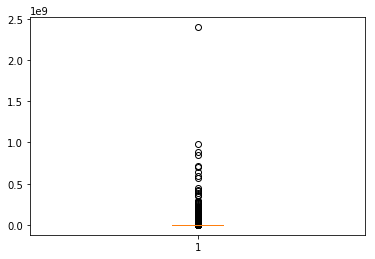

In [6]:
fig, ax = plt.subplots()
ax.boxplot(df[df["SALE_PRICE"]>0]["SALE_PRICE"]);

We find the range of the 'SALE_PRICE' varies a lot.
To wipe out unregular observation, We limit the price range from USD 100,000 to 100,000,000. 
which means, we exculde following percentage of data.

In [7]:
sum((df["SALE_PRICE"]<100000) | (df["SALE_PRICE"]>100000000))/len(df["SALE_PRICE"])

0.030197634927779368

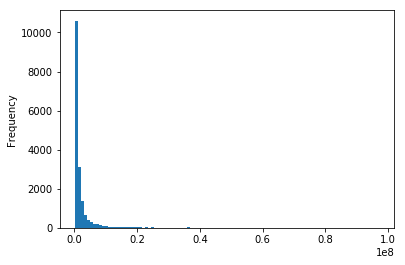

In [8]:
df[(df["SALE_PRICE"]>100000) & (df["SALE_PRICE"]<100000000)
  ]["SALE_PRICE"].plot.hist(bins=100);

Still, the range varies a lot. So we will take a log10.

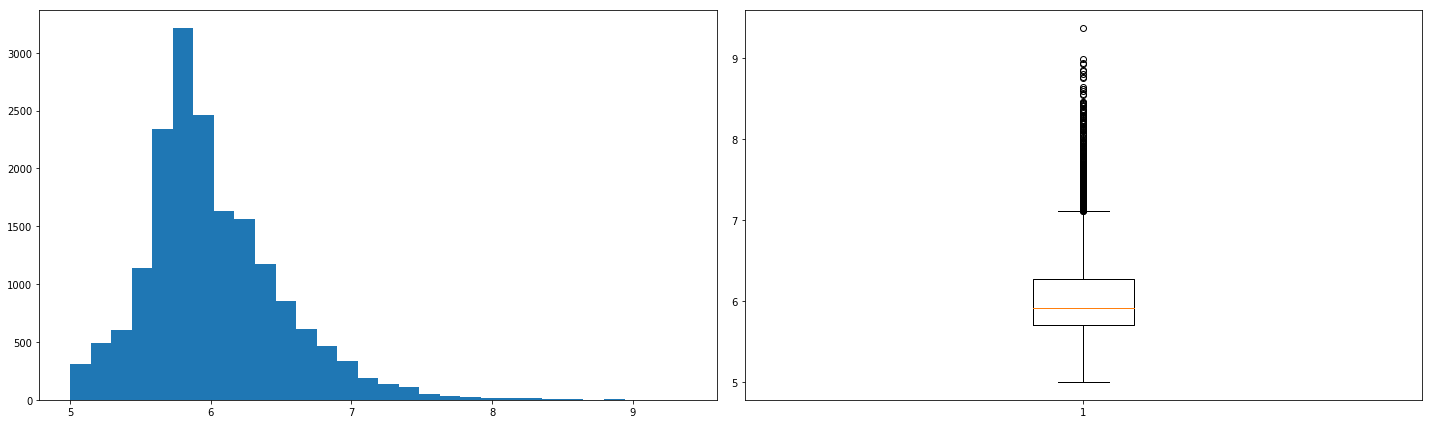

In [9]:
df["SALE_PRICE"] = df["SALE_PRICE"].replace(0, np.NaN)
df["Logged_SALE_PRICE"] = df["SALE_PRICE"].apply(np.log10)

rows = 1
cols = 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(10*cols, 6*rows))
axs = axs.flatten()
axs[0].hist(df[(df["Logged_SALE_PRICE"]>5)]["Logged_SALE_PRICE"], bins=30);
axs[1].boxplot(df[(df["Logged_SALE_PRICE"]>5)]["Logged_SALE_PRICE"]);
plt.tight_layout()   


So, it seems better than before. So, we will use our target value as Logged_SALE_PRICE.

## Another transformation we will need 

We have 'YEAR_BUILT' data which is a data when the building built.

However, the data itself has no mean as we need the "AGE" of the building.

So, we will create new variable called "AGE".

In [10]:
df["YEAR_BUILT"] = df["YEAR_BUILT"].replace(0, np.NaN)
df["SALE_DATE"] = df["SALE_DATE"].replace(0, np.NaN)
df["AGE"] = df["SALE_DATE"].dt.year - df["YEAR_BUILT"]
df["AGE"].head()

0    158.0
1    158.0
2    118.0
3    119.0
4    118.0
Name: AGE, dtype: float64

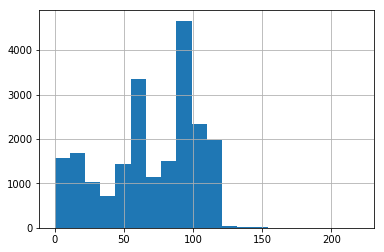

In [11]:
df["AGE"].hist(bins=20)

Also, the MONTH might be affect the value of the real estate if the other conditions hold:

So, we will create new variable called "SALE MONTH".

In [12]:
df["SALE_MONTH"] = df["SALE_DATE"].dt.month.astype(int)

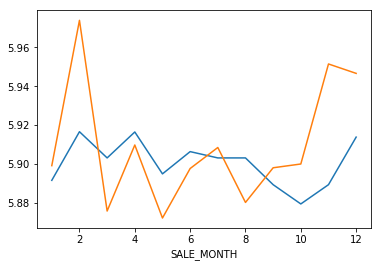

In [13]:
df.groupby("SALE_MONTH")["Logged_SALE_PRICE"].median().plot()
df.groupby("SALE_MONTH")["Logged_SALE_PRICE"].mean().plot()

## Data Plot with Logged_SALE_PRICE

### Categorical Variables and what they look like:

We select some variables 


In [14]:
df=df[df["SALE_PRICE"]!=df["SALE_PRICE"].max()]

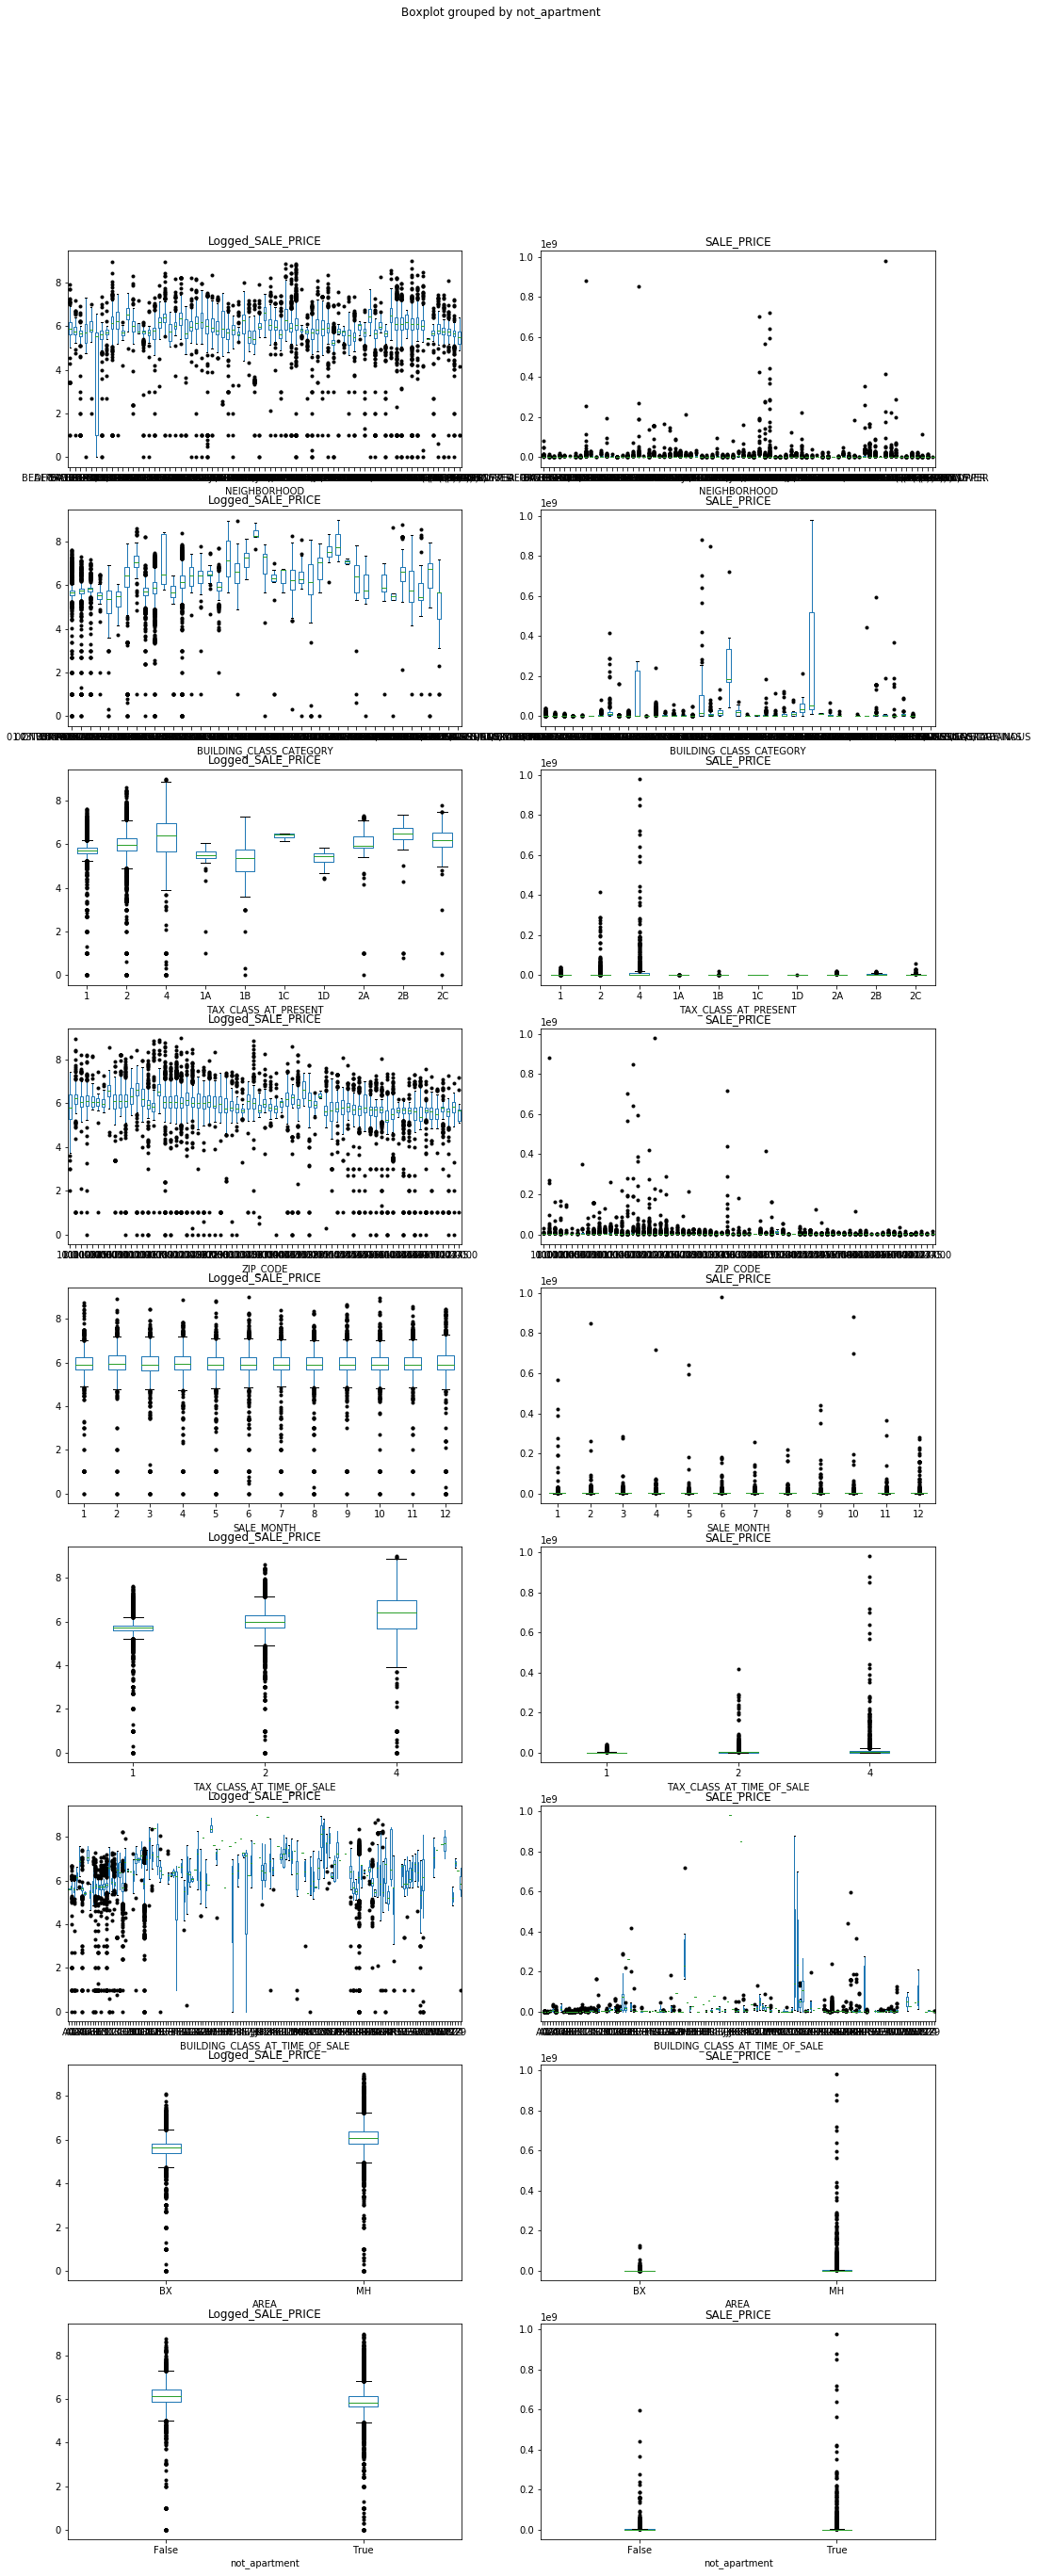

In [15]:
forboxplot = ['NEIGHBORHOOD','BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_PRESENT', 'ZIP_CODE',"SALE_MONTH", 
              'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE','AREA','not_apartment',]

rows = len(forboxplot)
cols = 2 
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8*cols, 5*rows))

j=0

for i in forboxplot:
    df.boxplot("Logged_SALE_PRICE", i, grid=False, sym='k.', ax=axes[j, 0])
    df.boxplot("SALE_PRICE", i, grid=False, sym='k.', ax=axes[j, 1])
    j += 1


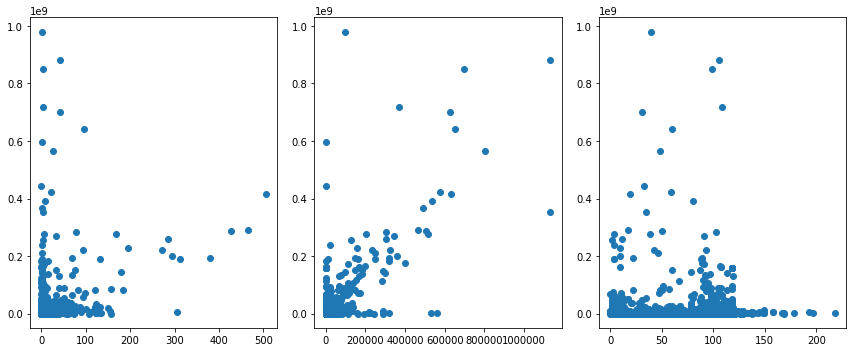

In [16]:
rows = 1
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(4*cols, 5*rows))
axs = axs.flatten()
j=0
features_selected = features_selected=['TOTAL_UNITS', 'GROSS_SQUARE_FEET','AGE']
for i in features_selected:
    axs[j].scatter(x=i, y="SALE_PRICE",data=df)
    j = j+1
plt.tight_layout()   


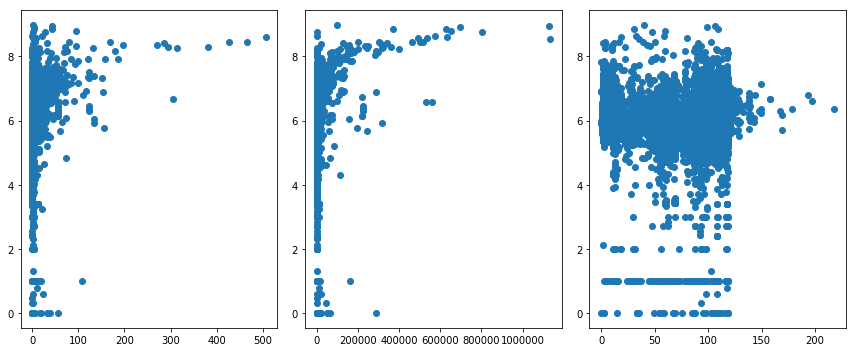

In [17]:
rows = 1
cols = 3

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(4*cols, 5*rows))
axs = axs.flatten()
j=0
features_selected = features_selected=['TOTAL_UNITS', 'GROSS_SQUARE_FEET','AGE']
for i in features_selected:
    axs[j].scatter(x=i, y="Logged_SALE_PRICE",data=df)
    j = j+1
plt.tight_layout()   


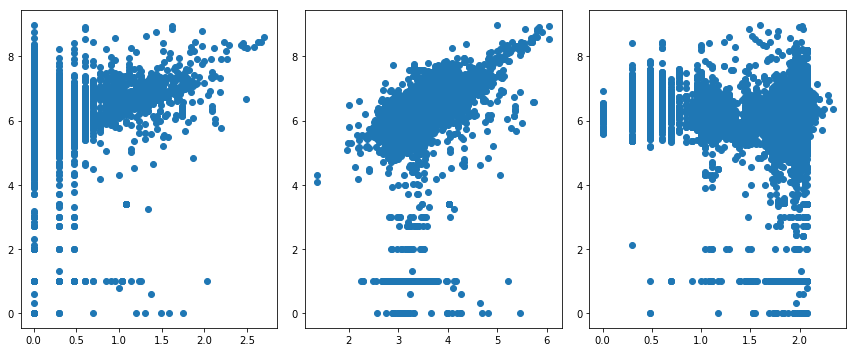

In [18]:
df["Logged_TOTAL_UNITS"] = df["TOTAL_UNITS"].replace(0,np.NaN).apply(np.log10)
df["Logged_GROSS_SQUARE_FEET"] = df["GROSS_SQUARE_FEET"].replace(0,np.NaN).apply(np.log10)
df["Logged_AGE"] = df["AGE"].replace(0,np.NaN).apply(np.log10)

logged_features_selected=['Logged_TOTAL_UNITS', 'Logged_GROSS_SQUARE_FEET', 'Logged_AGE']


fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(4*cols, 5*rows))
axs = axs.flatten()
j=0
for i in logged_features_selected:
    axs[j].scatter(x=i, y="Logged_SALE_PRICE",data=df)
    j = j+1
plt.tight_layout()   



# Data Preparation

We made the data understanding using only from Manhattan & Bronx.

We use all the 2018 data from NYC.

In [19]:
df_mh=pd.read_excel("rollingsales_manhattan.xls",skiprows=4)
# df_mh.columns=df_mh.columns.str.replace(' ', '_')
df_mh.columns.tolist()

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BLOCK',
 'LOT',
 'EASE-MENT',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'APARTMENT NUMBER',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'TAX CLASS AT TIME OF SALE',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE PRICE',
 'SALE DATE']

In [20]:
def load_data():
#     col=['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE','SALE PRICE']
    df_mh=pd.read_excel("rollingsales_manhattan.xls",skiprows=4)
#     df_mh=get_columns(df_mh,col)
    
    df_bk=pd.read_excel("rollingsales_brooklyn.xls",skiprows=4)
#     df_bk=get_columns(df_bk,col)
    
    df_bx=pd.read_excel("rollingsales_bronx.xls",skiprows=4)
#     df_bx=get_columns(df_bx,col)
    
    df_qs=pd.read_excel("rollingsales_queens.xls",skiprows=4)
#     df_qs=get_columns(df_qs,col)
    
    df_si=pd.read_excel("rollingsales_statenisland.xls",skiprows=4)
#     df_si=get_columns(df_si,col)
    
    df2018=pd.concat([df_mh,df_bk,df_bx,df_qs,df_si])
    
#     df_mh_17=pd.read_excel("2017_manhattan.xls",skiprows=4)
#     df_mh_17=get_columns(df_mh_17,col)
    
#     df_bk_17=pd.read_excel("2017_brooklyn.xls",skiprows=4)
#     df_bk_17=get_columns(df_bk_17,col)
    
#     df_bx_17=pd.read_excel("2017_bronx.xls",skiprows=4)
#     df_bx_17=get_columns(df_bx_17,col)
    
#     df_qs_17=pd.read_excel("2017_queens.xls",skiprows=4)
#     df_qs_17=get_columns(df_qs_17,col)
    
#     df_si_17=pd.read_excel("2017_statenisland.xls",skiprows=4)
#     df_si_17=get_columns(df_si_17,col)
    
#     df=pd.concat([df2018,df_mh_17,df_bk_17,df_bx_17,df_qs_17,df_si_17])
    df=df2018
    df=df.drop('EASE-MENT', 1)
    df=df.drop('APARTMENT NUMBER', 1)
    df=df.dropna()
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [21]:
df=load_data()

Then, we make the data clean:

In [22]:
df = df[df["SALE_PRICE"]!=0]

In [23]:
df["SALE_PRICE"] = df["SALE_PRICE"].replace(0, np.NaN)
df["YEAR_BUILT"] = df["YEAR_BUILT"].replace(0, np.NaN)
df["SALE_DATE"] = df["SALE_DATE"].replace(0, np.NaN)
df["SALE_MONTH"] = df["SALE_DATE"].dt.month.astype(int)

Then, we create some variables such as:
'SALE_MONTH', 'Logged_SALE_PRICE', 'AGE', 'Logged_TOTAL_UNITS', 'Logged_GROSS_SQUARE_FEET', 'Logged_AGE,

In [24]:
df["Logged_SALE_PRICE"] = df["SALE_PRICE"].apply(np.log10)
df["AGE"] = df["SALE_DATE"].dt.year - df["YEAR_BUILT"]
df["Logged_TOTAL_UNITS"] = df["TOTAL_UNITS"].replace(0,np.NaN).apply(np.log10)
df["Logged_GROSS_SQUARE_FEET"] = df["GROSS_SQUARE_FEET"].replace(0,np.NaN).apply(np.log10)
df["Logged_AGE"] = df["AGE"].replace(0,np.NaN).apply(np.log10)
df=df[df["Logged_SALE_PRICE"]!=0]

Now, we have following data:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56832 entries, 0 to 8384
Data columns (total 25 columns):
BOROUGH                           56832 non-null int64
NEIGHBORHOOD                      56832 non-null object
BUILDING_CLASS_CATEGORY           56832 non-null object
TAX_CLASS_AT_PRESENT              56832 non-null object
BLOCK                             56832 non-null int64
LOT                               56832 non-null int64
BUILDING_CLASS_AT_PRESENT         56832 non-null object
ADDRESS                           56832 non-null object
ZIP_CODE                          56832 non-null float64
RESIDENTIAL_UNITS                 56832 non-null float64
COMMERCIAL_UNITS                  56832 non-null float64
TOTAL_UNITS                       56832 non-null float64
LAND_SQUARE_FEET                  56832 non-null float64
GROSS_SQUARE_FEET                 56832 non-null float64
YEAR_BUILT                        53240 non-null float64
TAX_CLASS_AT_TIME_OF_SALE         56832 non-null

In [48]:
df = df.dropna()

# Modeling 

We will make an Regression, first Target Variables = SALE_PRICE (Not SALE_PRICE)

In [49]:
def selec_features(features):
    df_select=df[features]
    df_select=df_select[df_select['SALE_PRICE']>10000]
    X = df_select.drop(['SALE_PRICE'], axis=1)
    Y = df_select['SALE_PRICE']
    return X,Y

In [56]:
# select neighborhood / BLOCK + GROSS_SQUARE_FEET
features_selected=[
 'BOROUGH',
#  'NEIGHBORHOOD',
 'BUILDING_CLASS_CATEGORY',
 'TAX_CLASS_AT_PRESENT',
 'BLOCK',
 'LOT',
#  'BUILDING_CLASS_AT_PRESENT',
#  'ADDRESS',
#  'APARTMENT_NUMBER',
# 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE',
#  'BUILDING_CLASS_AT_TIME_OF_SALE',
 'SALE_PRICE',
# 'SALE_MONTH', 
# 'Logged_SALE_PRICE', 
# 'AGE',
# 'Logged_TOTAL_UNITS', 
# 'Logged_GROSS_SQUARE_FEET',
# 'Logged_AGE'
]
# features_selected=['BLOCK','GROSS_SQUARE_FEET','SALE_PRICE']

X, Y = selec_features(features_selected)
X = pd.get_dummies(X, columns=['BOROUGH','BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_PRESENT','TAX_CLASS_AT_TIME_OF_SALE'])
# X=pd.get_dummies(X, columns=['BLOCK'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37303 entries, 0 to 8380
Data columns (total 58 columns):
BLOCK                                                                 37303 non-null int64
LOT                                                                   37303 non-null int64
RESIDENTIAL_UNITS                                                     37303 non-null float64
COMMERCIAL_UNITS                                                      37303 non-null float64
TOTAL_UNITS                                                           37303 non-null float64
LAND_SQUARE_FEET                                                      37303 non-null float64
GROSS_SQUARE_FEET                                                     37303 non-null float64
YEAR_BUILT                                                            37303 non-null float64
BOROUGH_1                                                             37303 non-null uint8
BOROUGH_2                                                    

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# def rmse(y_test,y_pred):
#       return np.sqrt(mean_squared_error(y_test,y_pred))

def model_score(model):
    model=model
    model.fit(X_train, Y_train)
    Y_pred=model.predict(X_test)
    score=model.score(X_test, Y_test)
#     rmse=rmse(Y_test,Y_pred)
    return score

In [59]:
model=RandomForestRegressor(max_depth=50)
print("features_selected:", features_selected)
print("RandomForestRegressor:"+str(model_score(model)))
s = cross_val_score(model, X_train,Y_train, cv=10).mean()
print("cross_val_score",s)


features_selected: ['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE']


C:\Users\ryouen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor:0.5410085607475548
cross_val_score 0.5628908486834062


In [60]:
model=GradientBoostingRegressor(max_depth=6,learning_rate=0.05,n_estimators=500)
print("features_selected:", features_selected)
score=model_score(model)
print("GradientBoostingRegressor:"+str(score))
importance = model.feature_importances_
importance.argsort()

features_selected: ['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE']
GradientBoostingRegressor:0.5474597346970513


array([51, 24, 40, 16, 15, 50, 36, 14, 20, 52, 55, 42, 39, 47, 22, 37, 30,
       53, 34, 23, 13, 38, 54, 41, 32, 33,  9, 29, 45, 12, 46, 27, 11, 31,
       44, 49, 18, 10, 19, 57, 56, 43, 17, 48, 25,  2,  8, 21,  4,  3,  1,
       26, 28,  5,  7,  0, 35,  6], dtype=int64)

In [61]:
importance = model.feature_importances_
importance.argsort()

array([51, 24, 40, 16, 15, 50, 36, 14, 20, 52, 55, 42, 39, 47, 22, 37, 30,
       53, 34, 23, 13, 38, 54, 41, 32, 33,  9, 29, 45, 12, 46, 27, 11, 31,
       44, 49, 18, 10, 19, 57, 56, 43, 17, 48, 25,  2,  8, 21,  4,  3,  1,
       26, 28,  5,  7,  0, 35,  6], dtype=int64)

# Next, Target Variables = "Logged_SALE_PRICE"


In [63]:
def selec_features(features):
    df_select=df[features]
    df_select=df_select[df_select['Logged_SALE_PRICE']>5]
    X = df_select.drop(['Logged_SALE_PRICE'], axis=1)
    Y = df_select['Logged_SALE_PRICE']
    return X,Y

# select neighborhood / BLOCK + GROSS_SQUARE_FEET
features_selected=[
 'BOROUGH',
#  'NEIGHBORHOOD',
 'BUILDING_CLASS_CATEGORY',
 'TAX_CLASS_AT_PRESENT',
 'BLOCK',
 'LOT',
#  'BUILDING_CLASS_AT_PRESENT',
#  'ADDRESS',
#  'APARTMENT_NUMBER',
# 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE',
#  'BUILDING_CLASS_AT_TIME_OF_SALE',
# 'SALE_PRICE',
# 'SALE_MONTH', 
 'Logged_SALE_PRICE', 
 'AGE',
 'Logged_TOTAL_UNITS', 
 'Logged_GROSS_SQUARE_FEET',
 'Logged_AGE'
]

X, Y = selec_features(features_selected)
X = pd.get_dummies(X, columns=['BOROUGH','BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_PRESENT','TAX_CLASS_AT_TIME_OF_SALE'])
# X=pd.get_dummies(X, columns=['BLOCK'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36834 entries, 0 to 8380
Data columns (total 62 columns):
BLOCK                                                                 36834 non-null int64
LOT                                                                   36834 non-null int64
RESIDENTIAL_UNITS                                                     36834 non-null float64
COMMERCIAL_UNITS                                                      36834 non-null float64
TOTAL_UNITS                                                           36834 non-null float64
LAND_SQUARE_FEET                                                      36834 non-null float64
GROSS_SQUARE_FEET                                                     36834 non-null float64
YEAR_BUILT                                                            36834 non-null float64
AGE                                                                   36834 non-null float64
Logged_TOTAL_UNITS                                         

In [64]:
model=RandomForestRegressor(max_depth=50)
print("features_selected:", features_selected)
print("RandomForestRegressor:"+str(model_score(model)))
s = cross_val_score(model, X_train,Y_train, cv=10).mean()
print("cross_val_score",s)


features_selected: ['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'Logged_SALE_PRICE', 'AGE', 'Logged_TOTAL_UNITS', 'Logged_GROSS_SQUARE_FEET', 'Logged_AGE']


C:\Users\ryouen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor:0.5123779836637676
cross_val_score 0.367881760999072


In [65]:
model=GradientBoostingRegressor(max_depth=6,learning_rate=0.05,n_estimators=500)
print("features_selected:", features_selected)
score=model_score(model)
print("GradientBoostingRegressor:"+str(score))
importance = model.feature_importances_
importance.argsort()

features_selected: ['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'Logged_SALE_PRICE', 'AGE', 'Logged_TOTAL_UNITS', 'Logged_GROSS_SQUARE_FEET', 'Logged_AGE']
GradientBoostingRegressor:0.571176519590729


array([24, 16, 51, 40, 50, 36, 15, 20, 14, 55, 52, 54, 47, 42, 22, 37, 30,
       39, 53, 29, 38, 34, 13, 41, 32, 33, 23,  9, 45, 12, 46, 27, 44, 31,
       19, 57, 18, 49, 10, 43, 56, 17, 48, 11, 25,  2,  8, 21,  4, 26,  3,
        1, 28,  5,  0,  7, 35,  6], dtype=int64)